In [50]:
from trainer import UncertaintyTrainer
import os
import numpy as np
import pandas
import torch
from module.config import loadConfig, showConfig
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from torchvision import transforms

os.environ['CUDA_VISIBLE_DEVICES'] = "2"

class_map = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship', 'truck']
config_path = "./result/cifar_noise_fix_encoder_none_lr1e2/config.yaml"
gpu = 1
epoch = 8

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [51]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top
    predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res  

In [52]:
def show_probs(probs):
    plt.figure(figsize= (8,8))
    probs_mean = torch.mean(probs, dim=0, keepdim=False)
    plt.bar(np.arange(0, 10), probs_mean)
    for data in probs:
        plt.plot(np.arange(0, 10), data)
    plt.xticks(np.arange(0, 10)) # train epochs
    plt.xlabel(class_map)
    plt.yticks(np.arange(0, 1.1, 0.1)) # train epochs
    plt.show()

In [53]:
def show(image):
#     image = Image.open(RESULT_IMAGE_PATH)
    plt.figure(figsize= (2,2))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [54]:
def run(index, loader, probs_all, target_val):
    data = loader.dataset[index]
    label_y =target_val[index]
    image_x = data[0]
#     label_y = data[1]

    image_x = invTrans(image_x)
    image = image_x.permute(1, 2, 0)
    show(image)
    print("label_y : ", label_y)
    show_probs(probs_all[:, index].cpu())

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() and gpu != "-1" else "cpu")
config = loadConfig(config_path)
config['noise_type'] = "none"
trainer = UncertaintyTrainer(config, device)

Files already downloaded and verified
Files already downloaded and verified
Training T : 1.0
Number of trainable parameters of Point CNF: 179537


In [56]:
model_path = f'result/{config["output_folder"]}/flow_{str(epoch).zfill(2)}.pt'
encoder_path = f'result/{config["output_folder"]}/encoder_{str(epoch).zfill(2)}.pt'
trainer.load(model_path)
trainer.load_encoder(encoder_path)

## val_loader

In [57]:
MC_sample = 1
mean = 0
std = 0

probs_val, target_val, _, probs_all_val  = trainer.sampling(trainer.val_loader, MC_sample, mean, std)
acc = accuracy(probs_val,  target_val, topk=(1,))[0].cpu().item()
print("acc : ", acc)

39it [00:11,  3.36it/s]

acc :  9.995993614196777


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


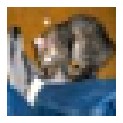

label_y :  tensor(3)


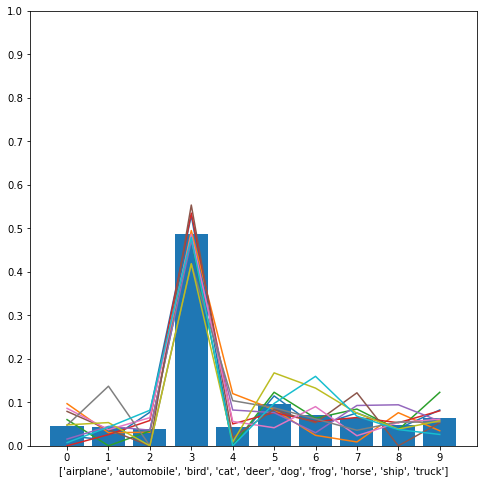

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


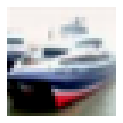

label_y :  tensor(8)


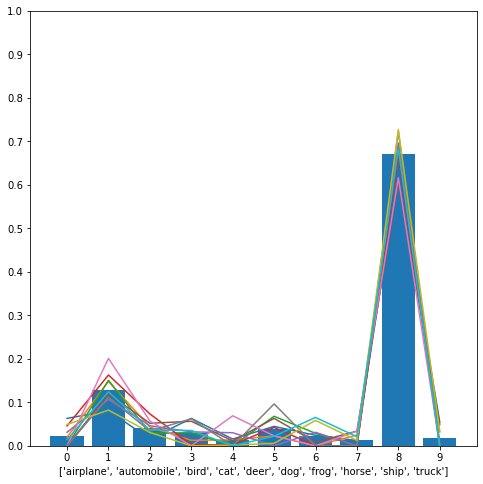

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


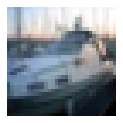

label_y :  tensor(8)


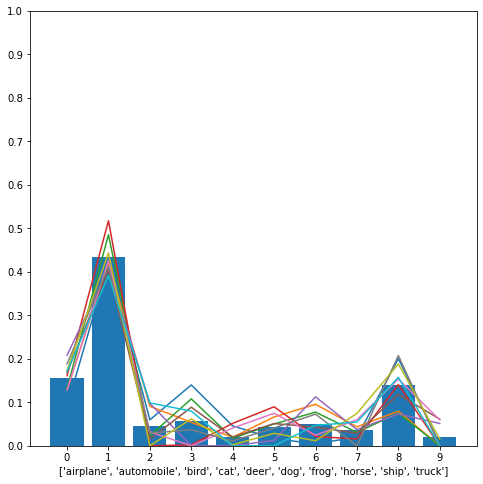

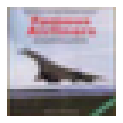

label_y :  tensor(0)


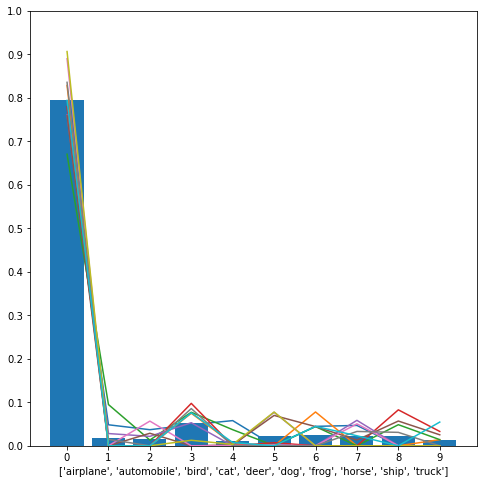

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


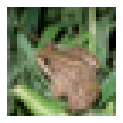

label_y :  tensor(6)


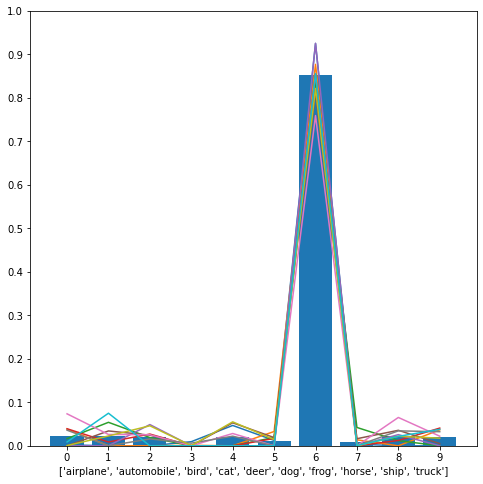

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


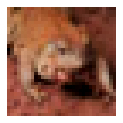

label_y :  tensor(6)


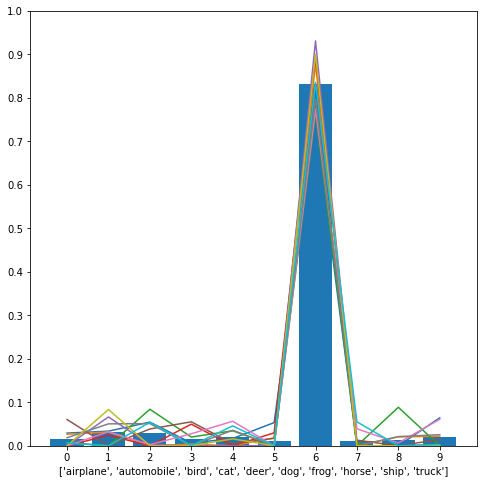

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


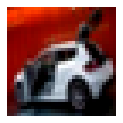

label_y :  tensor(1)


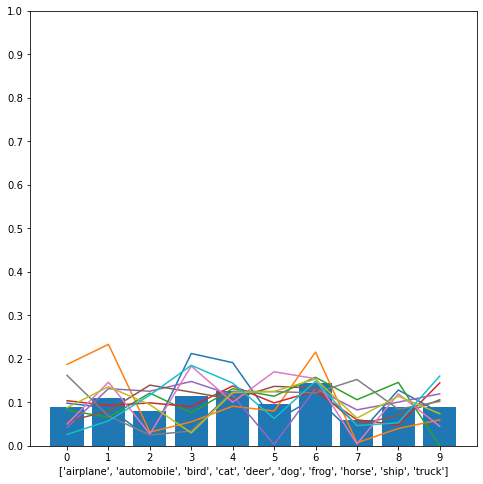

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


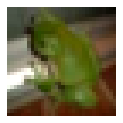

label_y :  tensor(6)


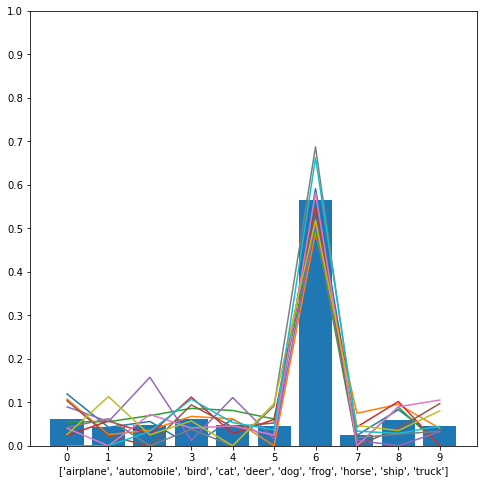

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


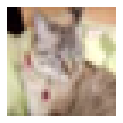

label_y :  tensor(3)


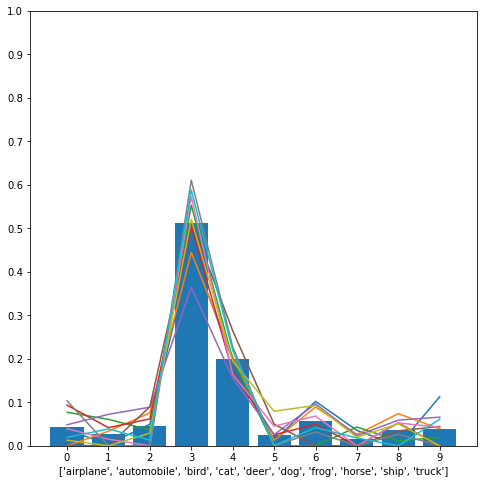

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


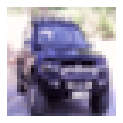

label_y :  tensor(1)


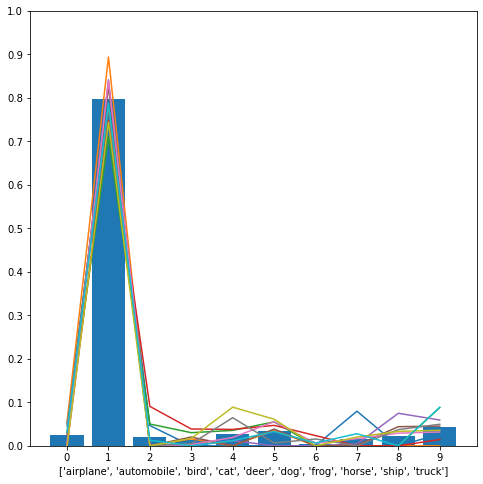

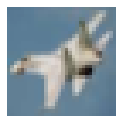

label_y :  tensor(0)


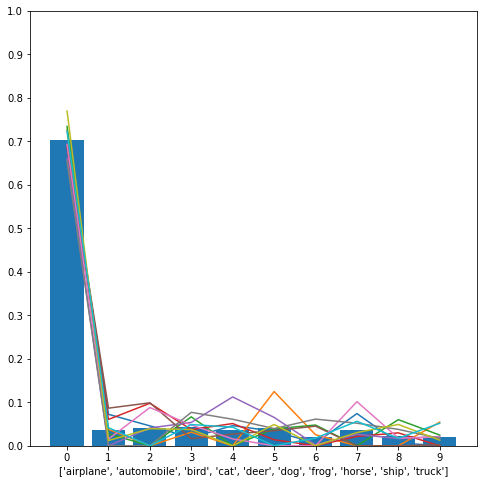

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


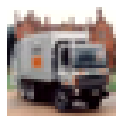

label_y :  tensor(9)


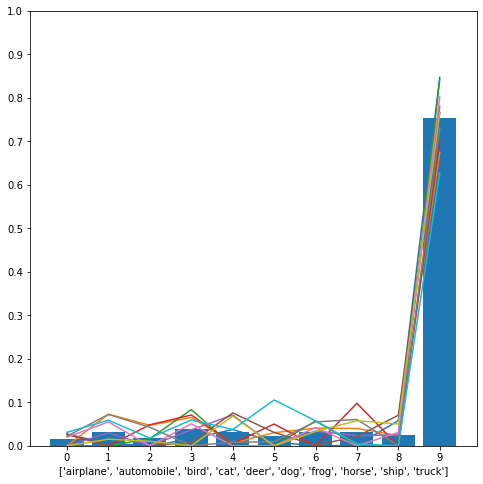

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


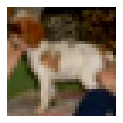

label_y :  tensor(5)


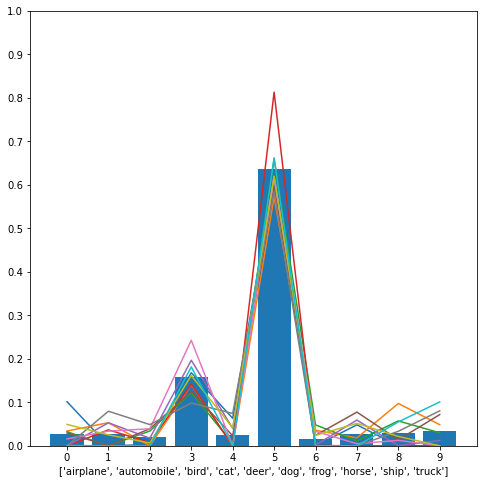

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


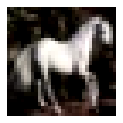

label_y :  tensor(7)


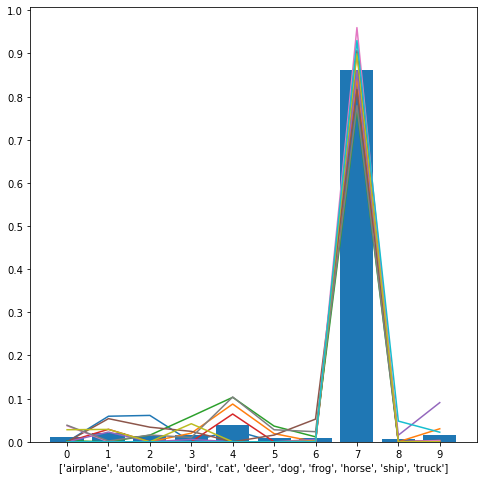

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


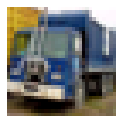

label_y :  tensor(9)


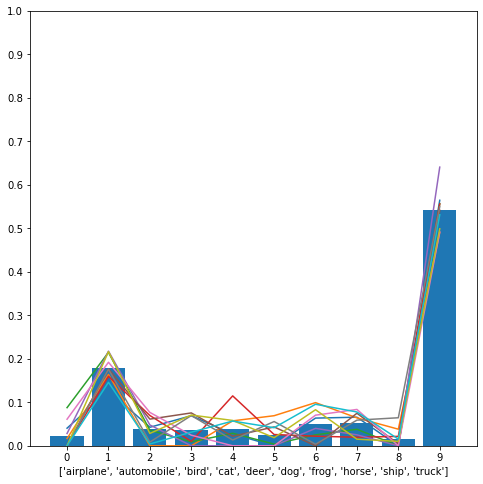

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


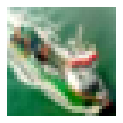

label_y :  tensor(8)


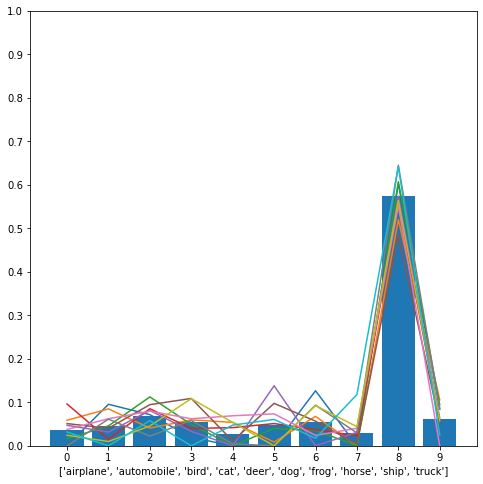

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


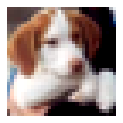

label_y :  tensor(5)


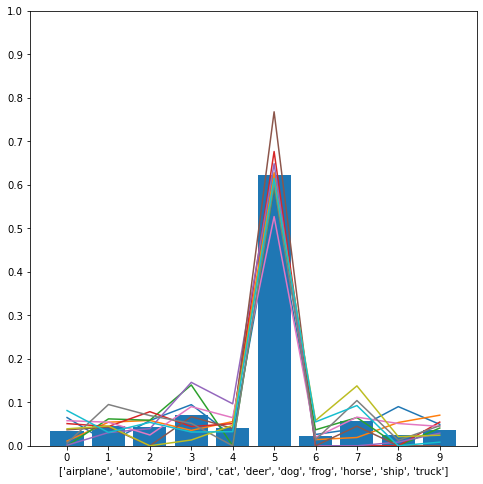

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


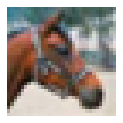

label_y :  tensor(7)


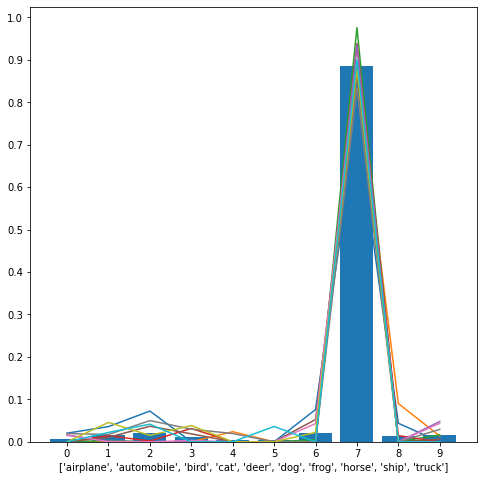

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


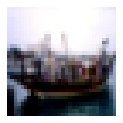

label_y :  tensor(8)


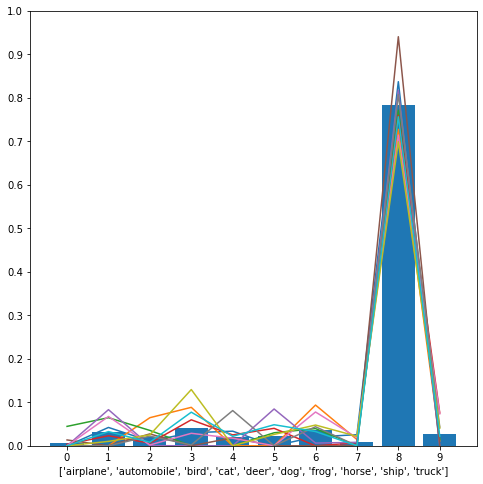

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


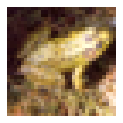

label_y :  tensor(6)


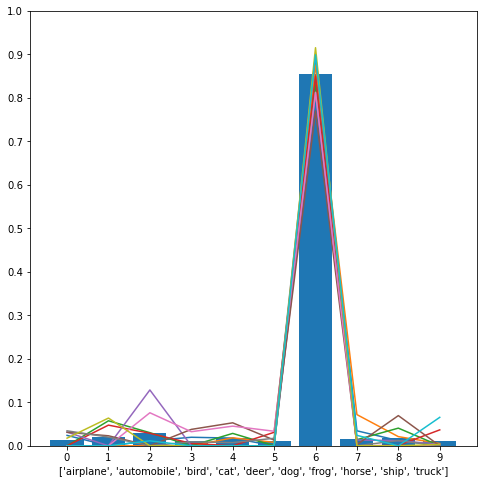

In [51]:
for i in range(20):
    run(i, trainer.val_loader, probs_all_val, target_val)

## train loader

In [49]:
MC_sample = 10
mean = 0
std = 0.2

probs_train, target_train, _, probs_all_train  = trainer.sampling(trainer.train_loader, MC_sample, mean, std)
acc = accuracy(probs_train,  target_train, topk=(1,))[0].cpu().item()
print("acc : ", acc)

7it [00:06,  1.08it/s]


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


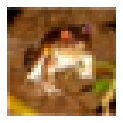

label_y :  tensor(6)


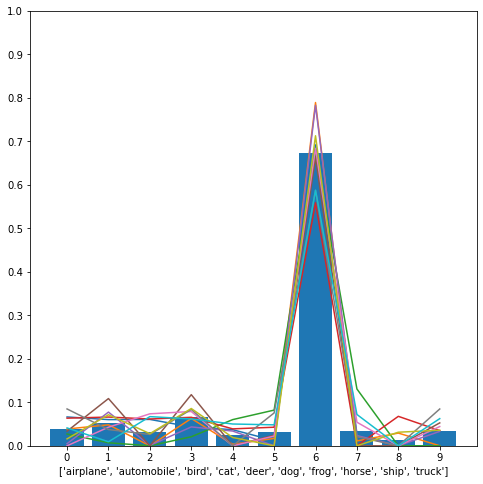

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


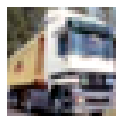

label_y :  tensor(9)


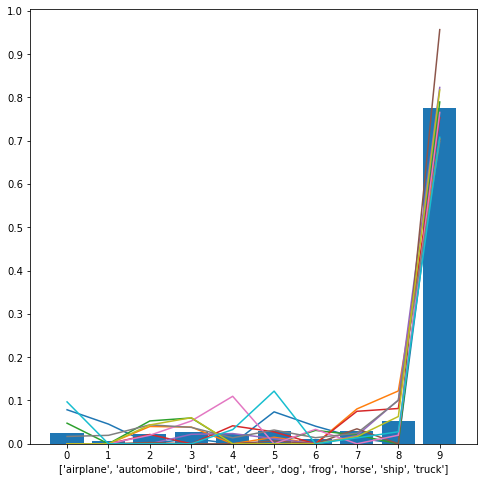

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


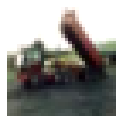

label_y :  tensor(9)


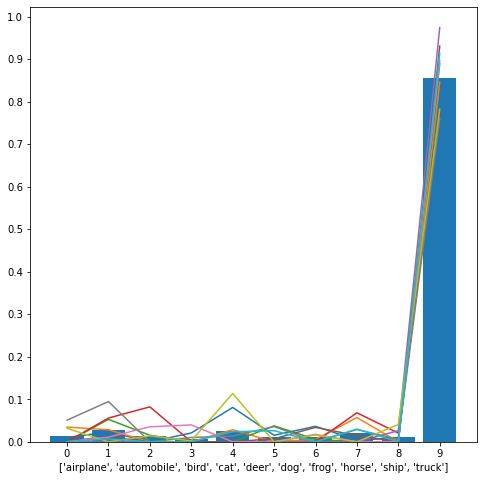

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


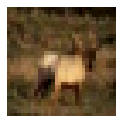

label_y :  tensor(4)


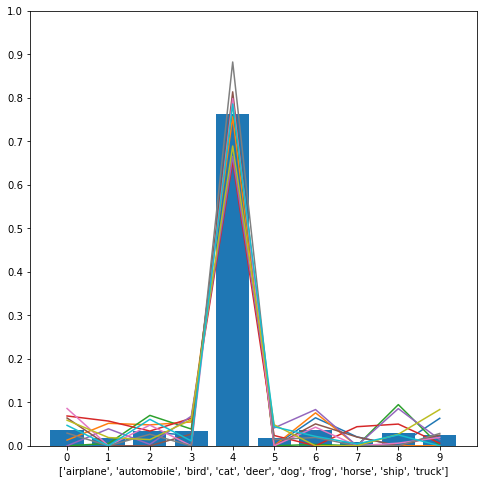

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


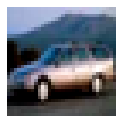

label_y :  tensor(1)


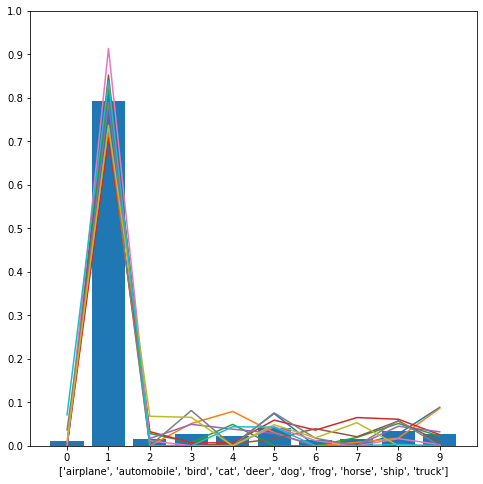

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


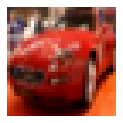

label_y :  tensor(1)


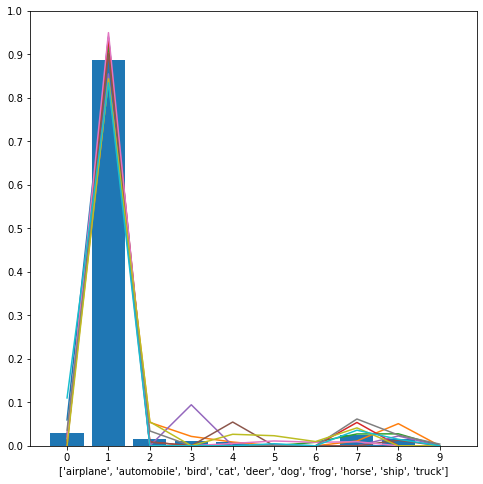

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


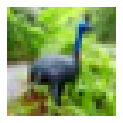

label_y :  tensor(2)


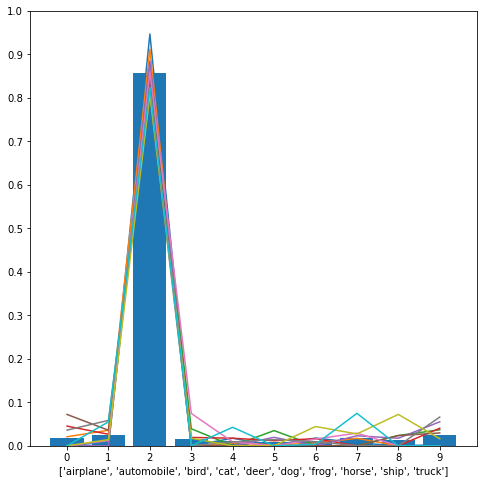

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


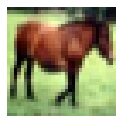

label_y :  tensor(7)


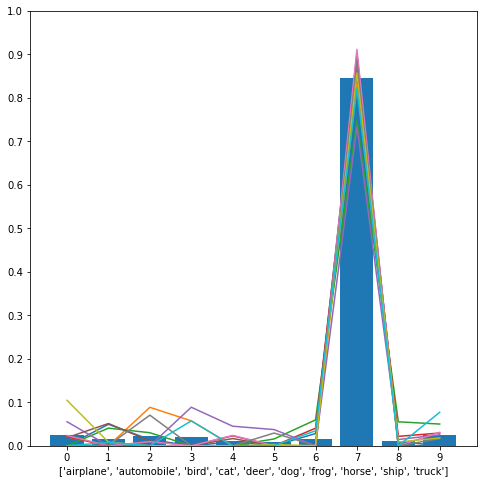

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


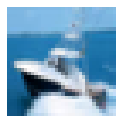

label_y :  tensor(8)


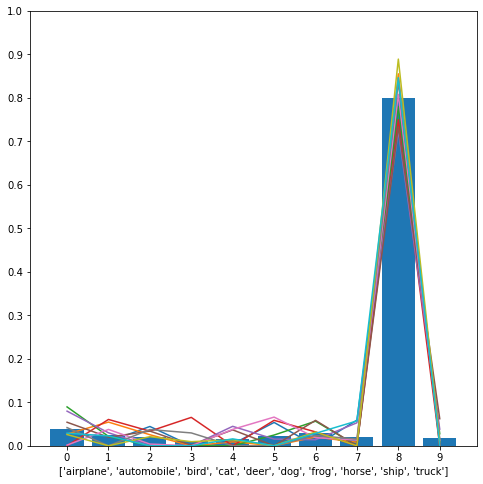

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


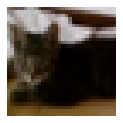

label_y :  tensor(3)


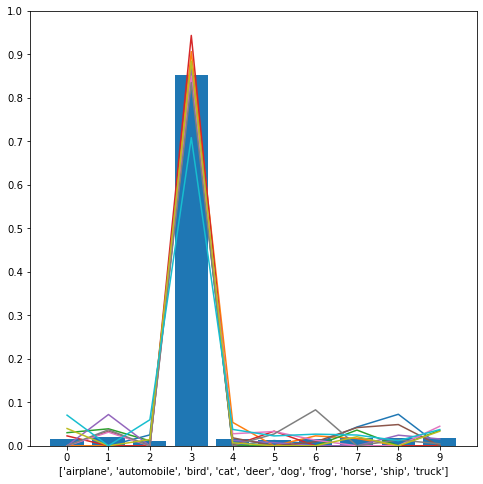

In [10]:
for i in range(10):
    run(i, trainer.train_loader, probs_all_train, target_train)